In [3]:
api_key = 'mdeqlkih5n1165zrzr12ef7h'
api_secret = '2i226o40eck9h9cbfp3gus6mvdc72bt5u22bf16cybje5a1071'

Create Dataframe, filter out data looking only for controlled substance sales

In [4]:
import pandas as pd
from io import StringIO

import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import quote

queries = [
    {
        "limit": 84838,
        "name": "drugs",
        "output_file": "data/drug_crime.csv",
        "url": "https://data.cityofnewyork.us/resource/qgea-i56i.csv",
        "filters": quote("""$where=pd_desc like '%CONTROLLED%SUBSTANCE%SALE%'""".strip(), safe=':/?&=')
    },
    {
        "limit": 84838,
        "name": "DOF: Summary of Neighborhood Sales by Neighborhood Citywide by Borough",
        "output_file": "data/geo_borough_prices.csv",
        "url": "https://data.cityofnewyork.us/resource/5ebm-myj7.csv",
        "filters": ""
    }
]

for query in queries:
    url = query['url']
    limit = query["limit"]
    filters = query["filters"]
    print("Downloading filtered dataset called", query["name"])
    print("Filters:", filters)
    offset = 0
    drugs_df = pd.DataFrame()

    while True:
        current_url = f"""{url}?{filters}&$limit={limit}&$offset={offset}
        """.strip()
        response = requests.get(current_url, auth=HTTPBasicAuth(api_key, api_secret))

        if response.status_code == 200:
            csv_data = StringIO(response.text)
            df_temp = pd.read_csv(csv_data)

            # If df is not empty, append the new data
            if not df_temp.empty:
                print(f"Retrieved {drugs_df.shape} records")
                drugs_df = pd.concat([drugs_df, df_temp])
                offset += limit
            else:
                break
        else:
            raise Exception(f"Failed to retrieve data. Status code: {response.status_code}", response.json())
        
    # Save to file
    drugs_df.to_csv(query["output_file"], index=False)
    print("Saved to file", query["output_file"])


Filters: %24where=pd_desc%20like%20%27%25CONTROLLED%25SUBSTANCE%25SALE%25%27
Retrieved (0, 0) records
Saved to file data/drug_crime.csv
Filters: 
Retrieved (0, 0) records
Saved to file data/geo_borough_prices.csv


In [2]:
import pandas as pd
drugs_df = pd.read_csv("data/drug_crime.csv")
drugs_df = drugs_df.rename(columns={'boro_nm': 'borough'})

In [3]:
# Keep only subset of columns
drugs_df = drugs_df[['cmplnt_fr_dt', 'cmplnt_fr_tm', 'cmplnt_to_dt', 'cmplnt_to_tm', 'borough']]
drugs_df = drugs_df.dropna()

# Add year column for later merge
drugs_df['year'] = pd.to_datetime(drugs_df['cmplnt_fr_dt']).dt.year.astype(int)

drugs_df.head()

,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,borough,year
0,2023-12-30T00:00:00.000,20:00:00,2023-12-30T00:00:00.000,20:15:00,BRONX,2023
1,2023-12-24T00:00:00.000,18:38:00,2023-12-24T00:00:00.000,18:38:00,QUEENS,2023
2,2023-12-30T00:00:00.000,11:48:00,2023-12-30T00:00:00.000,11:49:00,MANHATTAN,2023
4,2023-12-29T00:00:00.000,14:18:00,2023-12-29T00:00:00.000,14:18:00,STATEN ISLAND,2023
5,2023-12-29T00:00:00.000,15:25:00,2023-12-29T00:00:00.000,15:25:00,STATEN ISLAND,2023


Get borough prices - avg from median of all housing types for borough

In [4]:
boro_df = pd.read_csv("data/geo_borough_prices.csv")
boro_df.head()

,borough,neighborhood,type_of_home,number_of_sales,lowest_sale_price,average_sale_price,median_sale_price,highest_sale_price,year
0,MANHATTAN,ALPHABET CITY,01 ONE FAMILY HOMES,1,593362,593362,593362,593362.0,2010
1,MANHATTAN,ALPHABET CITY,02 TWO FAMILY HOMES,1,1320000,1320000,1320000,1320000.0,2010
2,MANHATTAN,ALPHABET CITY,03 THREE FAMILY HOMES,1,900000,900000,900000,900000.0,2010
3,MANHATTAN,CHELSEA,01 ONE FAMILY HOMES,2,500000,2875000,2875000,5250000.0,2010
4,MANHATTAN,CHELSEA,02 TWO FAMILY HOMES,2,1306213,2603107,2603107,3900000.0,2010


In [5]:
# Keep only subset of columns
boro_df = boro_df[['borough', 'median_sale_price', 'year']]

In [6]:
# boro_df['year'] = pd.to_datetime(boro_df['year'], format='%Y')
boro_df.groupby(['borough', 'year'])['median_sale_price'].median()
average_df = boro_df.groupby(['borough', 'year']).mean().reset_index()
average_df = average_df.rename(columns={'median_sale_price': 'avg_price'})
average_df.to_csv("data/average_prices.csv", index=False)


In [7]:
merged_df = pd.merge(average_df, drugs_df, on=['borough', 'year'])


In [8]:
print(merged_df.head())
print(merged_df.shape)

  borough  year      avg_price             cmplnt_fr_dt cmplnt_fr_tm  \
0   BRONX  2010  415482.833333  2010-11-17T00:00:00.000     22:15:00   
1   BRONX  2010  415482.833333  2010-12-30T00:00:00.000     09:40:00   
2   BRONX  2010  415482.833333  2010-12-22T00:00:00.000     19:50:00   
3   BRONX  2010  415482.833333  2010-12-21T00:00:00.000     14:55:00   
4   BRONX  2010  415482.833333  2010-12-18T00:00:00.000     01:25:00   

              cmplnt_to_dt cmplnt_to_tm  
0  2020-11-17T00:00:00.000     22:16:00  
1  2010-12-30T00:00:00.000     09:45:00  
2  2010-12-22T00:00:00.000     19:57:00  
3  2010-12-21T00:00:00.000     15:00:00  
4  2010-12-18T00:00:00.000     01:30:00  
(10676, 7)


Create visualization
- when complaint is made by
    - hour
    - month


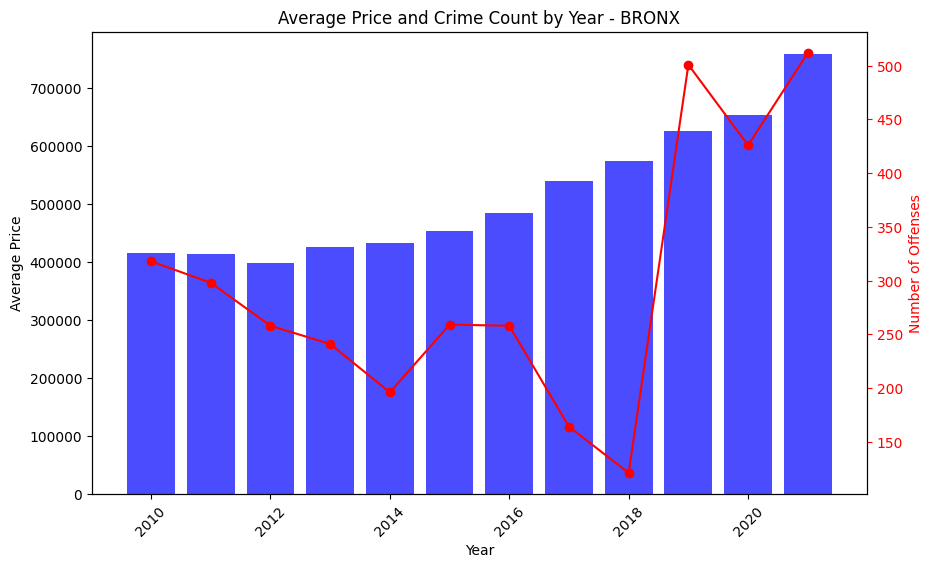

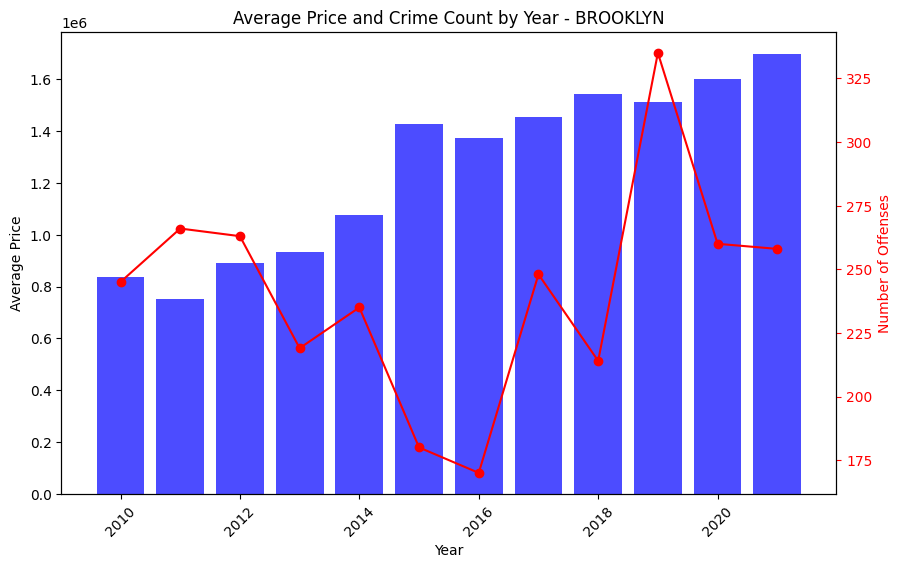

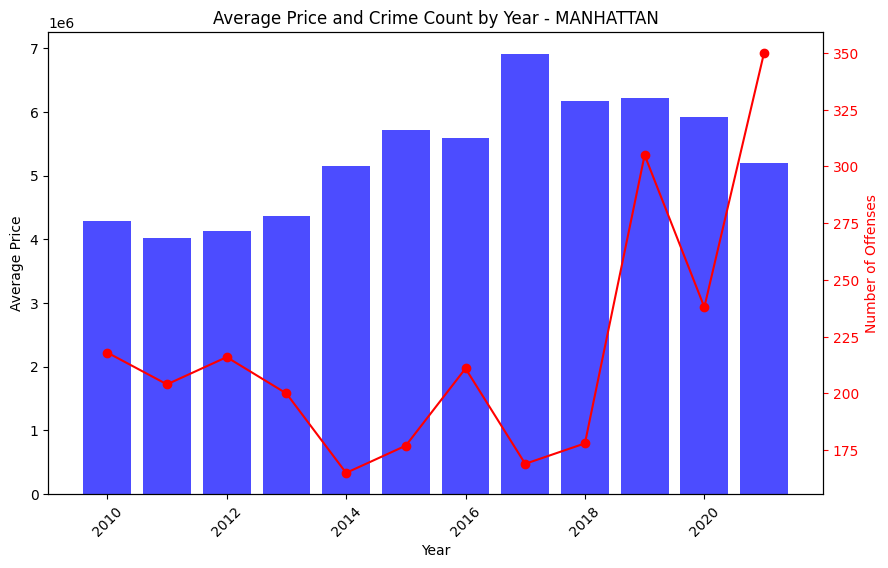

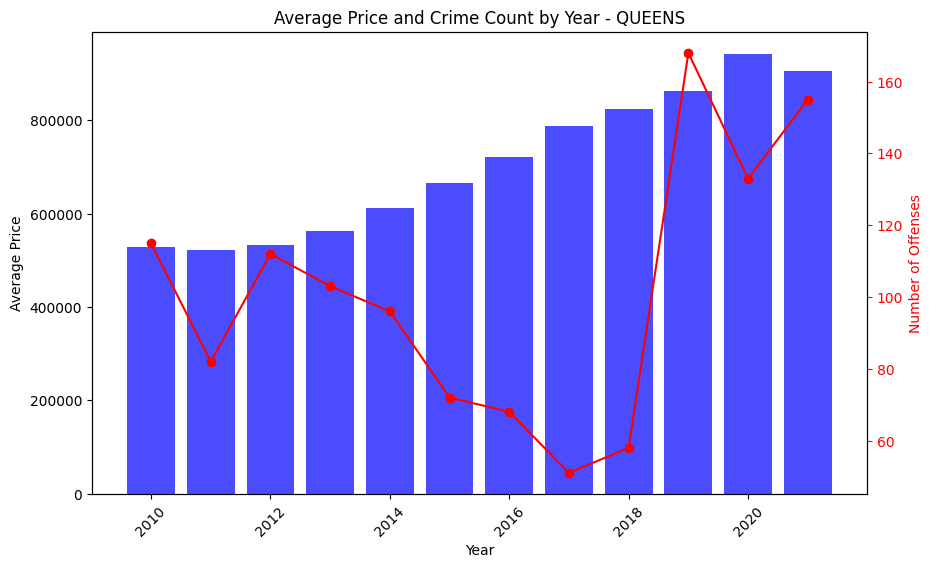

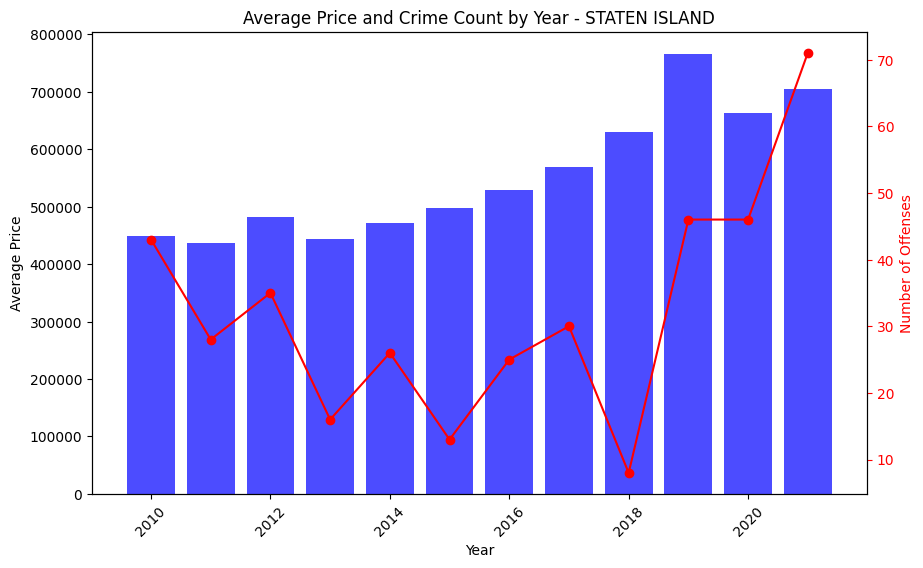

In [11]:
import matplotlib.pyplot as plt

# Get the unique boroughs
boroughs = merged_df['borough'].unique()

# Create a plot for each borough
for borough in boroughs:
    # Filter the data for the current borough
    borough_data = merged_df[merged_df['borough'] == borough]
    
    # Group the data by year and average price
    grouped_data = borough_data.groupby(['year', 'avg_price']).size().reset_index(name='crime_count')
    
    # Create the visualization
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot the average price
    ax1.bar(grouped_data['year'], grouped_data['avg_price'], color='blue', alpha=0.7)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Price')
    ax1.set_title(f'Average Price and Crime Count by Year - {borough}')
    ax1.tick_params(axis='x', rotation=45)
    
    # Create a second y-axis for the number of offenses
    ax2 = ax1.twinx()
    ax2.plot(grouped_data['year'], grouped_data['crime_count'], color='red', marker='o')
    ax2.set_ylabel('Number of Offenses', color='red')
    ax2.tick_params(axis='y', colors='red')
    
    plt.show()